In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import arcpy
%matplotlib inline
workspace= r"C:\Users\rauc8872\Documents\ArcGIS\Projects\CambridgeLiveBikeData\CambridgeLiveBikeData.gdb"
original_file_path = r"C:\Users\rauc8872\Documents\ArcGIS\Projects\CambridgeLiveBikeData\202307-bluebikes-tripdata\202307-bluebikes-tripdata.csv"
processed_file_path = r"C:\Users\rauc8872\Documents\ArcGIS\Projects\CambridgeLiveBikeData\202307-bluebikes-tripdata\20230720-bluebikes-cambridge.csv"
df  = pd.read_csv(original_file_path)

print("For the month of July, there are {} rides.".format(df.shape[0]))

For the month of July, there are 411509 rides.


#### Select trips that have either start or end station in Cambridge

In [52]:
# Function to check if the station ID matches the criteria
def check_station_id(station_id):
    if isinstance(station_id, str) and station_id.startswith('M'):
        try:
            station_number = int(station_id[1:])
            return 32001 <= station_number <= 32087
        except ValueError:
            return False
    return False
# Filter rows based on the criteria for start_station_id or end_station_id
cambridge_df = df[df.apply(lambda row: check_station_id(row['start_station_id']) or check_station_id(row['end_station_id']), axis=1)].copy()
print("Out of these, {} rides were from or to a station in Cambridge.".format(cambridge_df.shape[0]))
cambridge_df.head(5)

Out of these, 188875 rides were from or to a station in Cambridge.


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
7,72DAD656ADA460A6,docked_bike,2023-07-31 14:09:39,2023-07-31 14:40:08,Cambridge Main Library at Broadway / Trowbridg...,M32013,Northeastern University - North Parking Lot,B32012,42.373379,-71.111075,42.341814,-71.090179,member
8,0D759914BFDE6F29,docked_bike,2023-07-27 19:15:53,2023-07-27 19:46:24,Cambridge Main Library at Broadway / Trowbridg...,M32013,Hayes Square - Vine St at Moulton St,D32026,42.373379,-71.111075,42.377022,-71.056605,member
9,FEE09BC9C061278C,docked_bike,2023-07-26 22:14:28,2023-07-26 22:58:30,Roxbury Crossing T Stop - Columbus Ave at Trem...,C32001,Broad Canal Way at Third Street,M32082,42.331184,-71.095171,42.363045,-71.082871,casual
13,B95B1472F8242FBF,docked_bike,2023-07-24 19:58:35,2023-07-24 20:15:16,Cambridge Dept. of Public Works -147 Hampshire...,M32052,Christian Science Plaza - Massachusetts Ave at...,B32005,42.371197,-71.097599,42.343666,-71.085824,member
22,08AA4CE9E5D6ABF0,docked_bike,2023-07-12 17:31:49,2023-07-12 17:42:41,Binney St / Sixth St,M32027,Bunker Hill Community College,A32023,42.366088,-71.086336,42.374090,-71.069060,member


##### Length of the trips

In [53]:
# Convert the 'started_at' and 'ended_at' columns to datetime format
cambridge_df['started_at'] = pd.to_datetime(cambridge_df['started_at'])
cambridge_df['ended_at'] = pd.to_datetime(cambridge_df['ended_at'])

# Calculate the duration of each trip in minutes
cambridge_df['duration_minutes'] = (cambridge_df['ended_at'] - cambridge_df['started_at']).dt.total_seconds() / 60

# Remove any negative or zero durations, if they exist
cambridge_df = cambridge_df[cambridge_df['duration_minutes'] > 0]

# check how many rides were below half an hour, up to 2 hours, up to 8 hours and more than 8 hours.
bins = [0, 30, 60, 120, 480, 1440, 100000]
binned_data = pd.cut(cambridge_df['duration_minutes'], bins)
hist_as_series = binned_data.value_counts(sort = False).to_numpy()
print("{} trips between 0 and 30 minutes\n {} trips between 30 and 60 minutes\n {} trips between 1 and 2 hours\n {} trips between 2 and 8 hours\n {} trips longer than 8 hours".format(hist_as_series[0], hist_as_series[1], hist_as_series[2], hist_as_series[3], hist_as_series[4]))

167203 trips between 0 and 30 minutes
 16621 trips between 30 and 60 minutes
 3731 trips between 1 and 2 hours
 919 trips between 2 and 8 hours
 268 trips longer than 8 hours


#### How many trips did each day have?

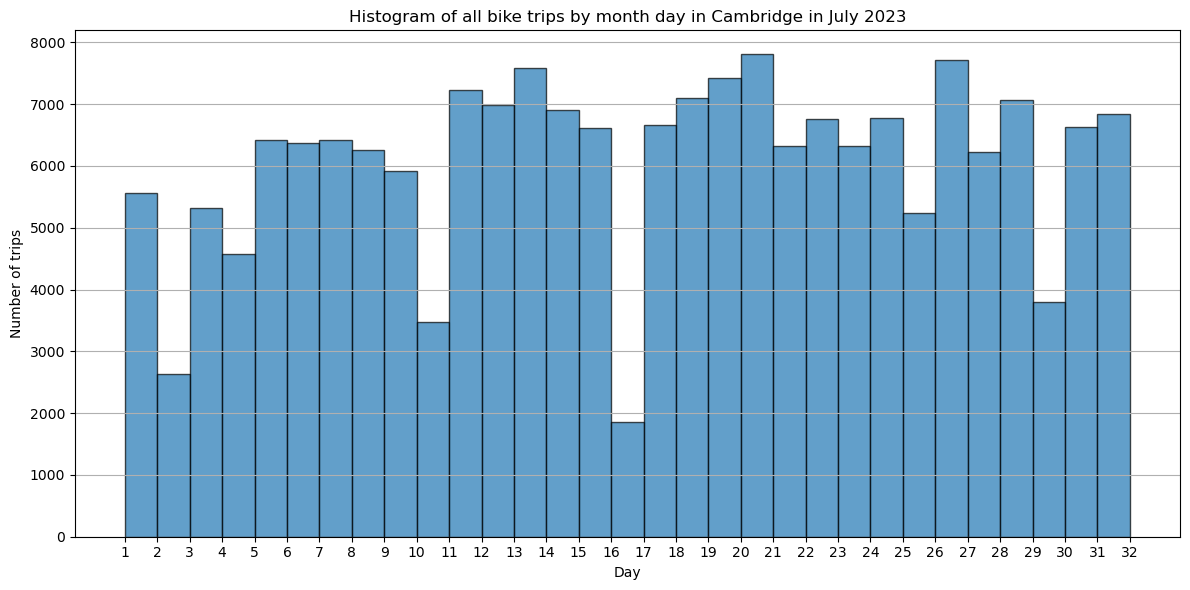

In [54]:
# Extract the day from the "started_at" column
cambridge_df['start_day'] = pd.to_datetime(cambridge_df['started_at']).dt.day

# Plot a histogram
plt.figure(figsize=(12, 6))
plt.hist(cambridge_df['start_day'], bins=range(1,33), edgecolor='black', alpha=0.7)
plt.title('Histogram of all bike trips by month day in Cambridge in July 2023')
plt.xlabel('Day')
plt.ylabel('Number of trips')
plt.xticks(range(1,33))
plt.grid(axis='y')
plt.tight_layout()

plt.show()

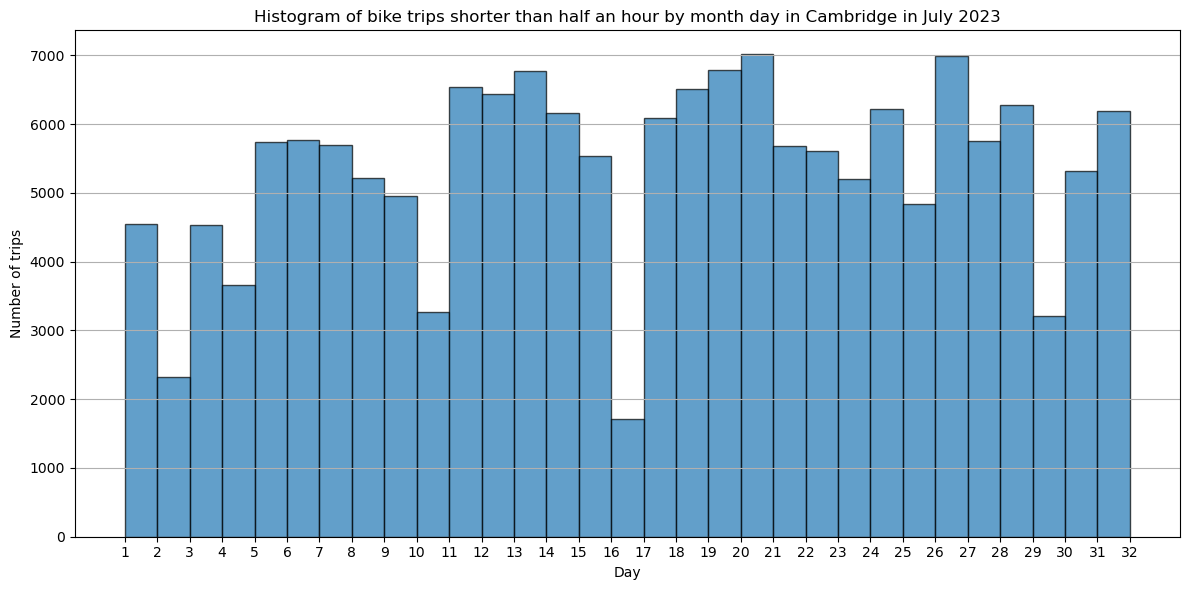

In [57]:
# Filter only trips that are on the same day and are shorter than half an hour
cambridge_df['end_day'] = pd.to_datetime(cambridge_df['ended_at']).dt.day
same_day_trips = cambridge_df[cambridge_df['start_day'] == cambridge_df['end_day']]
cambridge_short_trips_df = same_day_trips[same_day_trips['duration_minutes'] < 30]


# Plot a histogram
plt.figure(figsize=(12, 6))
plt.hist(cambridge_short_trips_df['start_day'], bins=range(1,33), edgecolor='black', alpha=0.7)
plt.title('Histogram of bike trips shorter than half an hour by month day in Cambridge in July 2023')
plt.xlabel('Day')
plt.ylabel('Number of trips')
plt.xticks(range(1,33))
plt.grid(axis='y')
plt.tight_layout()

plt.show()

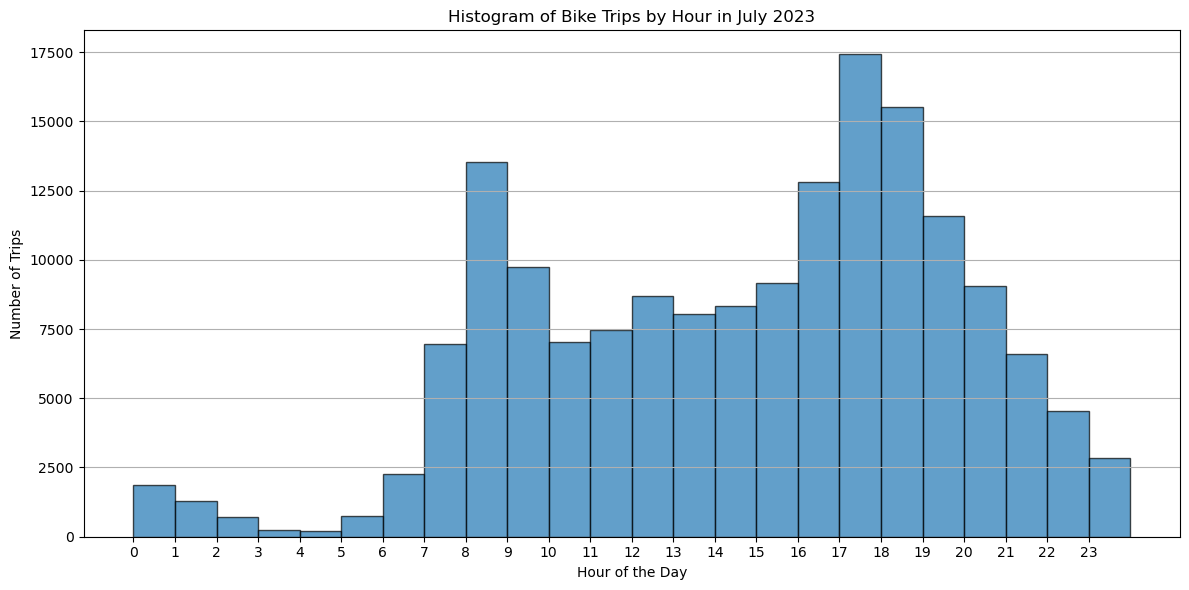

In [98]:
cambridge_short_trips_by_hour = pd.to_datetime(cambridge_short_trips_df['started_at']).dt.hour

# Plot a histogram
plt.figure(figsize=(12, 6))
plt.hist(cambridge_short_trips_by_hour, bins=range(25), edgecolor='black', alpha=0.7)
plt.title('Histogram of Bike Trips by Hour in July 2023')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.xticks(range(24))
plt.grid(axis='y')
plt.tight_layout()

plt.show()

#### Select a single day for further analysis

In [63]:
# Get top five days with most short trips in the same day
no_trips_per_day = cambridge_short_trips_df['start_day'].value_counts()
no_trips_per_day.head(5)

20    7014
26    6993
19    6795
13    6779
11    6543
Name: start_day, dtype: int64

In [68]:
# Select bike trips for the day with most bike trips
most_trips_day = no_trips_per_day.idxmax()
cambridge_trips_0720 = cambridge_short_trips_df[cambridge_short_trips_df['start_day'] == most_trips_day]
cambridge_trips_0720.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration_minutes,start_day,end_day
24,8E2B593D6BBF9F70,docked_bike,2023-07-20 18:24:41,2023-07-20 18:36:06,Binney St / Sixth St,M32027,Bunker Hill Community College,A32023,42.366088,-71.086336,42.374090,-71.069060,member,11.416667,20,20
95,0CBAA7A6B86DFF6F,docked_bike,2023-07-20 17:08:13,2023-07-20 17:25:27,MIT Stata Center at Vassar St / Main St,M32005,Christian Science Plaza - Massachusetts Ave at...,B32005,42.362131,-71.091156,42.343666,-71.085824,member,17.233333,20,20
105,12DE76C8215A9C15,docked_bike,2023-07-20 20:36:05,2023-07-20 20:53:05,Galileo Galilei Way at Main Street,M32072,Deerfield St at Commonwealth Ave,B32037,42.363004,-71.089740,42.349244,-71.097282,member,17.000000,20,20
134,9E87202EA75DAD1B,docked_bike,2023-07-20 08:28:56,2023-07-20 08:34:06,Harvard University River Houses at DeWolfe St ...,M32038,Harvard University / SEAS Cruft-Pierce Halls a...,M32023,42.369239,-71.116870,42.377945,-71.116865,member,5.166667,20,20
329,E355388F246A4734,docked_bike,2023-07-20 16:57:24,2023-07-20 17:26:21,Binney St / Sixth St,M32027,Broad Canal Way at Third Street,M32082,42.366088,-71.086336,42.363045,-71.082871,member,28.950000,20,20


In [71]:
# Sort by start time of the trip

cambridge_trips_0720_sorted = cambridge_trips_0720.sort_values(by='started_at')
cambridge_trips_0720_sorted.shape

(7014, 16)

In [79]:
# Export bike trips to csv
cambridge_trips_0720_sorted.to_csv(processed_file_path, index=False)

#### Convert the dataframe to origin and destination points feature layer

In [84]:
arcpy.env.workspace = workspace
in_table = processed_file_path
spatial_reference = arcpy.SpatialReference(4326)


<Result 'C:\\Users\\rauc8872\\Documents\\ArcGIS\\Projects\\CambridgeLiveBikeData\\CambridgeLiveBikeData.gdb\\bluebikes_origin'>

In [89]:
x_coords = "start_lng"
y_coords = "start_lat"
origin_points_fc = "bluebikes_origin"
arcpy.management.XYTableToPoint(in_table, origin_points_fc, x_coords, y_coords, coordinate_system=spatial_reference)

<Result 'C:\\Users\\rauc8872\\Documents\\ArcGIS\\Projects\\CambridgeLiveBikeData\\CambridgeLiveBikeData.gdb\\bluebikes_origin'>

In [86]:
x_coords_dest = "end_lng"
y_coords_dest = "end_lat"
destination_points_fc = "bluebikes_destination"
arcpy.management.XYTableToPoint(in_table, destination_points_fc, x_coords_dest, y_coords_dest, coordinate_system=spatial_reference)

<Result 'C:\\Users\\rauc8872\\Documents\\ArcGIS\\Projects\\CambridgeLiveBikeData\\CambridgeLiveBikeData.gdb\\bluebikes_destination'>

In [90]:
# Delete and rename fields for origin and destination

arcpy.management.DeleteField(origin_points_fc, ['rideable_type', "end_station_name", "end_station_id", "start_lat", "start_lng", "end_lat", "end_lng", "start_day", "end_day"])
arcpy.management.AlterField(origin_points_fc, "start_station_id", "station_id", "station_id")
arcpy.management.AlterField(origin_points_fc, "start_station_name", "station_name", "station_name")

arcpy.management.DeleteField(destination_points_fc, ['rideable_type', "start_station_name", "start_station_id", "start_lat", "start_lng", "end_lat", "end_lng", "start_day", "end_day"])
arcpy.management.AlterField(destination_points_fc, "end_station_id", "station_id", "station_id")
arcpy.management.AlterField(destination_points_fc, "end_station_name", "station_name", "station_name")

<Result 'bluebikes_origin'>

In [95]:
# Merge feature classes into a single bluebikes_route_stops feature class

route_stops_fc = "bluebikes_route_stops"

arcpy.management.Merge([origin_points_fc, destination_points_fc], route_stops_fc)

<Result 'C:\\Users\\rauc8872\\Documents\\ArcGIS\\Projects\\CambridgeLiveBikeData\\CambridgeLiveBikeData.gdb\\bluebikes_route_stops'>

<Result 'bluebikes_origin'>